# C4 metacalibration on cluster injections


In this notebook we will finally connect the dots, and apply the metacalibration algorithm to estimate the shear field around a galaxy cluster injected into the DC2 simulation.

## Objectives

    1 Use the metacalibration algorithm in the cluster lensing scenario

    2 Measure the tangential shear field induced by a galaxy cluster
   

## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * DC2 cutotut data files on disk
    
    * curated galaxy cluster member catalog (see A4 notebook)
       


## Output

    * tangential shear profile input vs measured for a galaxy cluster
    
    
The output files are placed in the `./data/` folder


## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [52]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.cosmology as cosmology

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.render.icl as icl
import synthetic.mcal as mcal

import galsim
import images # package from erin sheldon

import meds
import psfex # The python wrapper

pixel_scale = 0.2

*** Important *** set the `nprocess` value to the amount of CPU cores you are willing or allowed to use for this notebook

please consider your local server, e.g. don't run heavy calculations on public login nodes

In [2]:
# nprocess = 4
nprocess = 100

In [3]:
# output path for mock image, be sure to place it into a folder where you can write a few GBs of files 
out_path = "./data/"

# Prepare the cluster injection

In [4]:
table_path = './data/refdata/curated_table.h5'
table = pd.read_hdf(table_path, key="data")

ra_cen = 50.64516228577292
dec_cen = -40.228830895890404

mock_catalog_path = './data/refdata/curated_mock_catalog.h5'
mock_catalog = pd.read_hdf(mock_catalog_path, key="data")

## Create a shear profile

For illustration purposes, we are going to use an isothermal (power law) shear profile

In case you have other preferences, the below section is where you must modify the line-of-sight catalog

You can add magnification, or other shear profiles as your preferences dictate

In [5]:
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [6]:
image_offset=(2499.5, 2499.5)

xra = (mock_catalog['X'] - image_offset[0]) * pixel_scale / 60 # arcmin
ydec = (mock_catalog['Y'] - image_offset[1]) * pixel_scale / 60 # arcmin
dists = np.sqrt(xra**2 + ydec**2)

shears = np.sqrt(1 / dists  / 400) # just for illustration purposes
shears[shears > 0.8] = 0.8 # galsim cannot render very large shears properly

phis =  np.arctan2(ydec, xra)
es1 = (-1. * shears * np.cos(2 * phis))
es2 = (-1. * shears * np.sin(2 * phis))


e1 = mock_catalog['G1']
e2 = mock_catalog['G2']
vals1 = e1 + es1 - e1 * es1 - e2 * es2 # Calculate the sheared galaxy shape
vals2 = e2 + es2 - es1 * e2 + es2 * e1

tmp = np.sqrt(vals1**2. + vals2**2.)
ii = tmp > 0.9 # galsim cannot render very large shears properly, we must reduce the 
divs = 1. / (0.1 + tmp[ii])  
vals1[ii] *= divs
vals2[ii] *= divs

# Add shear only to galaxies, which are at z > 0.4,
# this is a super simple approximation, intended to showcase the functionality
jj = table['redshift_true'] > 0.4

mock_catalog.loc[jj, "G1"] = vals1[jj]
mock_catalog.loc[jj, "G2"] = vals2[jj]

## Render cluster injection

For this example, we are going to use a curated galaxy cluster member catalog

In [7]:
mock_cluster_path = './data/refdata/curated_cluster_model_v01-z0l0_15000_001.h5'
mock_cluster = pd.read_hdf(mock_cluster_path, key="data")

For this example, this is saved in the same database format (exact same columns) as the DC2 catalog which we used above, so we can simply concatenate them in pandas

In [8]:
mock_all = pd.concat((mock_cluster, mock_catalog))

In [9]:
# These are the approcimate noise levels we are going to use for mock images in this notebook
# g, r, i, z bands
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3

# This is the file name root, appended by bands
# we render only g, r, i as those already make a nice color image
file_name_tag = 'test_cluster_canvas_dc2_' #

for i, band in enumerate(("g", "r", "i")):
    name = out_path + file_name_tag + band
    print(name)
    fr = frame.Frame(mock_all.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render(nprocess=nprocess) 

./data/test_cluster_canvas_dc2_g
starting postage stamp calculations in 100 processes
./data/test_cluster_canvas_dc2_r
starting postage stamp calculations in 100 processes
./data/test_cluster_canvas_dc2_i
starting postage stamp calculations in 100 processes


## Create intra-cluster-light image

We are creating the ICL as a separate 2D array, for each pixel of the observation canvas. So that it can be manipulated as an image, added directly to the rendered galaxy catalogs. 

This way an arbitrary light profile can be added. In the following we are going to use the approach and codebase derived from Varga et al 2021, based on the parametrization of Gruen et al 2019, using the intra cluster light measurements of Zhang et al 2019.

In this approach, a doughnut shaped pseudo ICL model is calculated, which is the real ICL light profile from which the core Elliptical galaxy is subtracted out, so that the sum of the two components will agree with the observed light distribution.

We should note that the ICL can have an ellipticity in this model, for now simply taken as the orientation of the BCG.

***Right now we are going to place an intra cluster light profile centered around the center of the canvas!***

In [10]:
galpath = "./data/refdata/ICL/evolving_red_gal.dat"
mstarpath = "./data/refdata/ICL/mstar_des_i03.fit"
jk_profile_root = "./data/refdata/ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": -0.1356766444194723,
    "g2":0.0345231539560347,
    "imag": 17.76, # i band magnitude
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45 # in solar masses
z = 0.3 # cluster redshift


In [11]:
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)
di.get_icl()
ims_icl = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/render/icl.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((arr - pos) * k))


then we load the pre icl images:

In [12]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = out_path + 'test_cluster_canvas_dc2_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

./data/test_cluster_canvas_dc2_g.fits
./data/test_cluster_canvas_dc2_r.fits
./data/test_cluster_canvas_dc2_i.fits


So that we can simply add the two components together

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8703028559684753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8703590035438538


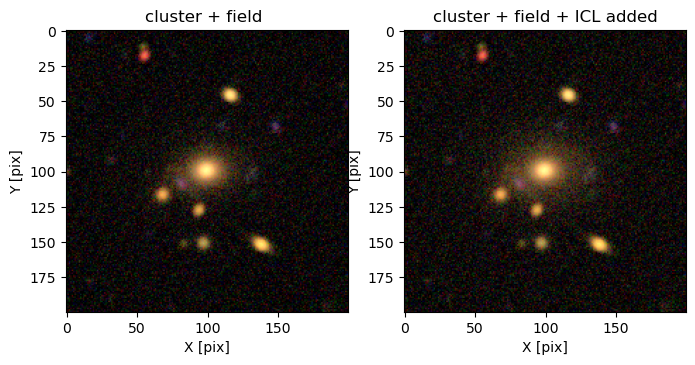

In [13]:
fig, axarr = plt.subplots(ncols=2, figsize=(8, 4))

ax = axarr[0]
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2] + pad,
                                ims_all[1] + pad,
                                ims_all[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin='upper')

ax.set_title("cluster + field ")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

ax = axarr[1]
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2] + ims_icl[2] + pad,
                                ims_all[1] + ims_icl[1] + pad,
                                ims_all[0] + ims_icl[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin='upper')

ax.set_title("cluster + field + ICL added")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

fig.savefig("./data/dc2_hp_icl_panel.png", bbox_inches='tight')

## Creating a deeper, detection image and weight map

source detection is traditionally done on coadded images, even when shear estimation is performed per-frame for greater performance.

For this reason, unlike in B1, B2, B3, we are going to create a single, deeper, detection frame

In [14]:
band = 'i'
name = out_path + 'test_canvas_' + band
print(name)
fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1., canvas_size=5000, config_se='data/configs/config.sex')
fr.render(nprocess=nprocess) 

./data/test_canvas_i
starting postage stamp calculations in 100 processes


Now we manually add up the ICL component to the deeper detection image (The ICL is rendered noise free)

In [30]:
fr_all = copy.deepcopy(fr)
fr_all.canvas += ims_icl[2]
fr_all.name = out_path + 'test_field+clust+icl_canvas_grid_low-isothermal_coadd_' + "i"
fr_all.write()

## running sextractor on the detection image

And running sextractor

In [34]:
fr_all.extract()

sex ./data/test_field+clust+icl_canvas_grid_low-isothermal_coadd_i.fits -c data/configs/config.sex -CATALOG_NAME ./data/test_field+clust+icl_canvas_grid_low-isothermal_coadd_i_cat.fits -CHECKIMAGE_NAME ./data/test_field+clust+icl_canvas_grid_low-isothermal_coadd_i_seg.fits


In [35]:
scat = fr_all.scat.copy()
seg = fio.read(out_path + "test_field+clust+icl_canvas_grid_low-isothermal_coadd_" + "i_seg.fits")

In [81]:
fr.canvas_size

5000

## Creating a multi epoch data system file (MEDS)

In [36]:
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size)) # this is set as 1, as in this example that's the noise std
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(fr_all.name + '_weight.fits', clobber=True)

Here we do a bit of filtering, we only want to select objects which are actually within the image proper, otherwise there are errors raised during shear measurement

In [96]:
pad = 50 # pixel from the edge of the image
mag_min = 20 # we don't want too bright
mag_max = 24 # or too faint objects in the shear catalog (NOTE, this right now is just a guess)
ii = (
    (scat["X_IMAGE"] > pad) &
    (scat["X_IMAGE"] < (fr_all.canvas_size - pad )) &
    (scat["Y_IMAGE"] > pad) &
    (scat["Y_IMAGE"] < (fr_all.canvas_size - pad )) &
    (scat["MAG_AUTO"] > mag_min) &
    (scat["MAG_AUTO"] < mag_max)
) 
objects = fr_all.scat.copy()[ii]

In [97]:
nimage = 1 # one exposure per object, we are simulating coadds with identical observational conditions
nobj = len(objects)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = objects['NUMBER'] # the source extractor ID, starts with 1, not 0...

# This the size of the bounding box for the object, should be adaptive based on the size of the source
box_sizes = np.round(objects["A_IMAGE"] * objects["B_IMAGE"] * 2 ) *2
box_sizes[box_sizes < 16] = 16 
obj_data['box_size'] = box_sizes

# The below are the positions of the source on the sky and in the image-
# The actual MEDS script uses the sky position based on the image WCS, but this is done completely under the hood
obj_data['ra'] = objects['ALPHAWIN_J2000'] + pixel_scale / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['dec'] = objects['DELTAWIN_J2000'] - pixel_scale / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['X_IMAGE'] = objects['X_IMAGE']
obj_data['Y_IMAGE'] = objects['Y_IMAGE']

In [98]:
path_image = fr_all.name + ".fits"
path_weight = fr_all.name + "_weight.fits"
path_seg = fr_all.name + "_seg.fits"

# Due to some memory reservation issues, we have to tell expicitely how long the longest filename will be.
path_length= np.max((len(path_image), len(path_seg), len(path_weight)))

image_info= meds.util.get_image_info_struct(nimage, path_length)

image_info['image_path'][0] = path_image
image_info['weight_path'][0] = path_weight
image_info['seg_path'][0] = path_seg
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

As in C3, we take the true galsim PSF model

In [99]:
pex = frame.MockPSF(fr_all.df.image_epsf)
psf_data = [pex,]

now all is set for running the MEDSMaker

In [100]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)
mm.write(out_path + "cluster.meds")

writing cutouts for: ['image', 'weight', 'seg']
file    1 of    1: 'b'./data/test_field+clust+icl_canvas_grid_low-isothermal_coadd_i.fits''
    first cut:    3670 of   3670 objects
    second cut:   3670 of   3670 objects
3670/3670 had ncut > 0
setting start rows and pixel count
total pixels: 3028228
setting psf layout for PSFEx


/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/meds/util.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phat = numpy.array([-1.0*sinp,cosp,0.0]).T


meds layout build time: 0.247699 seconds
opening output MEDS file: './data/cluster.meds'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic
    reserving psf mosaic
writing image cutouts
    1/1 image b'./data/test_field+clust+icl_canvas_grid_low-isothermal_coadd_i.fits'
    no background for image
writing weight cutouts
    1/1 weight b'./data/test_field+clust+icl_canvas_grid_low-isothermal_coadd_i_weight.fits'
writing seg cutouts
    1/1 seg b'./data/test_field+clust+icl_canvas_grid_low-isothermal_coadd_i_seg.fits'
writing psf cutouts
output is in: ./data/cluster.meds


Let's inspect some of the galaxies!

In [101]:
m = meds.MEDS(out_path + "cluster.meds")

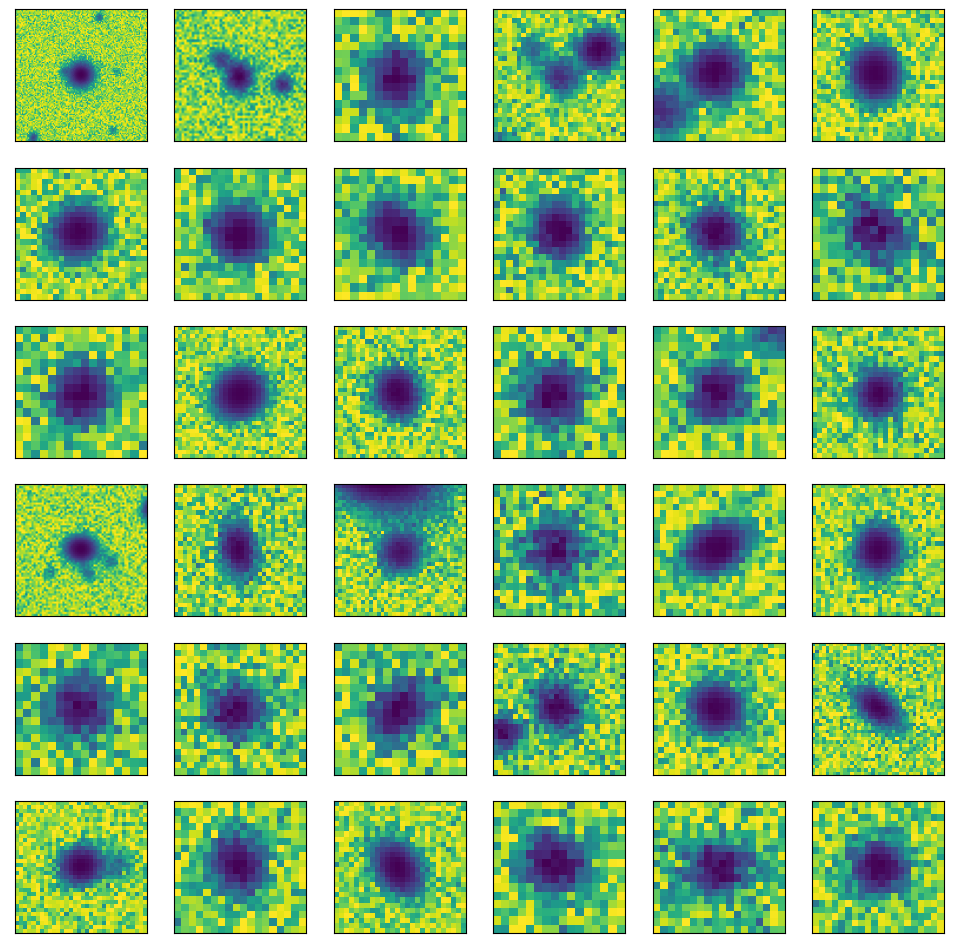

In [102]:
fig, axarr = plt.subplots(ncols=6, nrows=6, figsize=(12,12))
# fig.subplots_adjust(wspace=0.01)
for i, ax in enumerate(axarr.flatten()):
    im = m.get_cutout(i, 0, 'image')
    ax.imshow(np.arcsinh(im) / im)
    ax.set_xticks([])
    ax.set_yticks([])    
fig.savefig("./data/cluster_illustration_meds.png", bbox_inches="tight")

# Running metacalibration

In [103]:
input_name = out_path + "cluster.meds"

we have to prepare a set of instructions for the metacal runner

The actual calculation is split up to jobs, each processing a set of independent postage stamps, and the results are written to file

In [104]:
# The highest number of  objects to include from the sextractor detection catalog. 
maxnum = len(objects) # for the example, you might be better off reducing the number from all objects down to fewer galaxies.

In [105]:
outfile_names = out_path + "cluster_mcal" # file name root of output (will have additional _01 _02 etc appended to it)

infodicts = mcal.infomaker(maxnum, input_name, outfile_names, nchunk=nprocess)

In [106]:
mcal.multi_mcal(infodicts, nprocess=nprocess)

starting metacal calculations in 100 processes
     singular covariance
    pars at singular:     -0.3      -0.3  -8.15e-10  -2.55e-07     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3   9.7e-10  -2.37e-08     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  -1.84e-09  -1.05e-07     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  4.54e-09  -1.17e-06     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  2.61e-10  1.02e-06     0.304      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3   1.5e-09  -1.22e-07     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  -2.95e-09  -6.36e-08     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  -4.5e-09  -4.46e-08     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  2.81e-10  5.43e-07  

     singular covariance
    pars at singular:   -0.299    -0.301  -1.47e-09  2.28e-06     0.304      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  -5.29e-10  -1.85e-06     0.311      0.04 
Total fitting and stacking time: 42.46895694732666 seconds
Total fitting and stacking time: 42.479968309402466 seconds
Total fitting and stacking time: 42.598432302474976 seconds
     singular covariance
    pars at singular:     -0.3      -0.3  6.22e-11  1.66e-09     0.304      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  1.14e-09  -3.65e-08     0.311      0.04 
     singular covariance
    pars at singular:     -0.3      -0.3  2.17e-09  -2.21e-08     0.311      0.04 
     singular covariance
        pars at singular: singular covariance 
    -0.3      -0.3  -6.03e-10  5.96e-07     0.311      0.04     pars at singular:
     -0.3      -0.3  -2.51e-09  -2.8e-08     0.304      0.04 
Total fitting and stacking time: 43.553274154663086 seconds
     

     singular covariance
    pars at singular:     -0.3      -0.3  -5.38e-11   0.00978     0.311      0.04 
Total fitting and stacking time: 75.5008339881897 seconds


In [107]:
tab = mcal.collater(infodicts)

## And finally, let's measure the shear profile around the cluster!

This is without any foreground or background detection.

measuring photometric redshifts (photo-z) is far beyond the scope of this work

In [108]:
def get_tangential(xpos, ypos, e1, e2, center):
    """The tangential profile is measured around the center"""
    dists = np.sqrt((ypos - center[1])**2. + (xpos - center[0])**2.)
    phis = np.arctan2(ypos - center[1], xpos - center[0])
    tshears = -e1 * np.cos(2 * phis) - e2 * np.sin(2 * phis)
    return tshears, dists

In [125]:
def binned_signal(rvals, shears, redges, resps=None):
    """Calculates the mean shear in radial bins"""
    rcens = redges[:-1] + np.diff(redges) / 2.
    vals = np.zeros(len(rcens))
    vals_err = np.zeros(len(rcens)) # This is the error on the mean, not the std
    respvals = np.zeros(len(rcens))
    for i, tmp in enumerate(redges[:-1]):
        ii = np.where((rvals > redges[i]) & (rvals < redges[i + 1]))[0]
        vals[i] = np.mean(shears[ii])
        vals_err[i] = np.std(shears[ii]) / np.sqrt(len(ii))
        
        if resps is not None:
            respvals[i] = np.mean(resps[ii])
            
    return rcens, vals, vals_err, respvals
        

In [126]:
tshear, rarr = get_tangential(tab["X_IMAGE"], tab["Y_IMAGE"],
                              tab["g_noshear"][:, 0], tab["g_noshear"][:, 1],
                              (2499.5, 2499.5))
rarr *= pixel_scale / 60
resp = (tab["r11"] + tab["r22"]) / 2

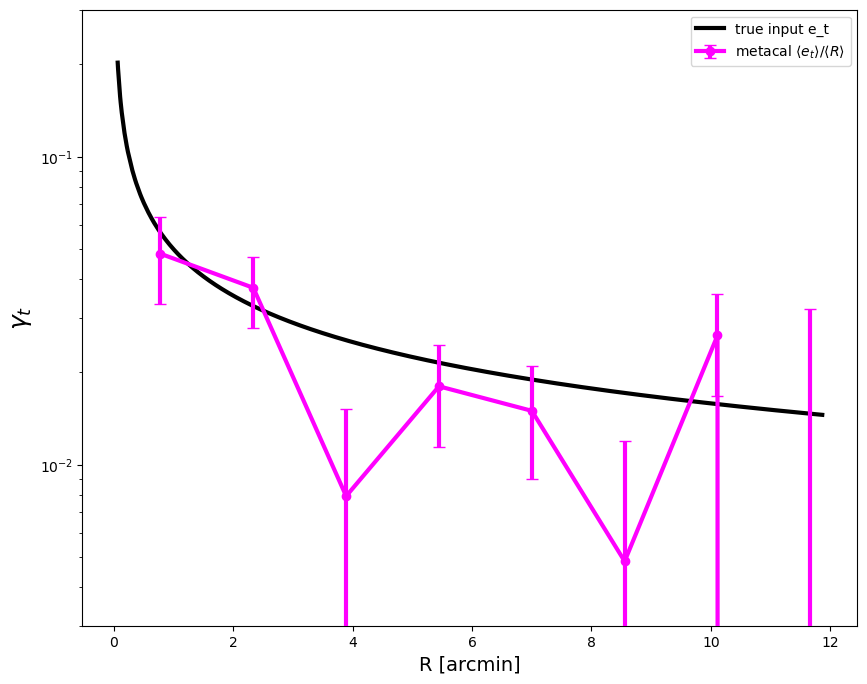

In [127]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# plot the truth curve
iorder = np.argsort(dists)
ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")


rcens, sraw, sraw_err, respvals = binned_signal(rarr, tshear, redges, resp)
ax.errorbar(rcens, sraw / respvals, sraw_err / respvals, label="metacal $\\langle e_t \\rangle / \\langle R \\rangle$",
            marker="o", color="magenta", lw=3, capsize=4, zorder=5)

ax.set_ylim(0.003,0.3)
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_ylabel("$\gamma_t$", fontsize=18)
ax.set_yscale("log")
ax.legend()
fig.savefig("metacal_clust_low-isothermal_cartoon_v01.png", bbox_inches="tight")

This looks, fantastic for a single cluster!

You might notice that the metacal signal is somewhat lower, this is to be expected, as we just blindly measured the shear of all sources

In reality we have to exclude cluster members (also blue cluster members, so a simple color cut does not solve it... but that is a different story.)